In [38]:
import sklearn.datasets
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from collections import defaultdict

np.random.seed(42)
results = defaultdict(list)

results["quantum"] = defaultdict(list)
results["classical"] = defaultdict(list)

for no_of_classes in [2,10]:
    for p in [3,4,5]:
        X = sklearn.datasets.load_digits(n_class=no_of_classes)

        scaler = StandardScaler().fit(X.data)
        X_scaled = scaler.transform(X.data)

        pca = PCA(n_components=p)
        pca.fit(X_scaled)
        X_transform_pca = pca.transform(X_scaled)

        y_scaled = 2 * (X.target - 0.5)

        X_train, X_test, y_train, y_test = train_test_split(X_transform_pca, y_scaled)
        
        for x in range(len(X_train)):
            X_train[x] = X_train[x]/np.linalg.norm(X_train[x])

        for x in range(len(X_test)):
            X_test[x] = X_test[x]/np.linalg.norm(X_test[x])

        n_qubits = len(X_train[0])
        
        print('Number of qubits being used : ', n_qubits)

        dev_kernel = qml.device("lightning.qubit", wires=n_qubits)

        projector = np.zeros((2**n_qubits, 2**n_qubits))
        projector[0, 0] = 1

        @qml.qnode(dev_kernel, interface="autograd")
        def kernel(x1, x2):
            AngleEmbedding(x1, wires=range(n_qubits))
            qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))            
            return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

        def kernel_matrix(A, B):
            return np.array([[kernel(a, b) for b in B] for a in A])

        qclassifier = SVC(kernel=kernel_matrix).fit(X_train, y_train)

        predictions = qclassifier.predict(X_test)
        score = accuracy_score(predictions, y_test)

        results['quantum'][no_of_classes].append((p,score))
        print (no_of_classes, p, score)f

        clf = svm.SVC(kernel='rbf')
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        results['classical'][no_of_classes].append((p,accuracy_score(predictions, y_test)))

print (results)

Number of qubits being used :  3
2 3 1.0
Number of qubits being used :  4
2 4 1.0
Number of qubits being used :  5
2 5 1.0
Number of qubits being used :  3
10 3 0.7022222222222222
Number of qubits being used :  4
10 4 0.7644444444444445
Number of qubits being used :  5
10 5 0.7977777777777778
defaultdict(<class 'list'>, {'quantum': defaultdict(<class 'list'>, {2: [(3, 1.0), (4, 1.0), (5, 1.0)], 10: [(3, 0.7022222222222222), (4, 0.7644444444444445), (5, 0.7977777777777778)]}), 'classical': defaultdict(<class 'list'>, {2: [(3, 1.0), (4, 1.0), (5, 1.0)], 10: [(3, 0.7088888888888889), (4, 0.7688888888888888), (5, 0.8244444444444444)]})})


No of dimensions used for 10 classes -  2


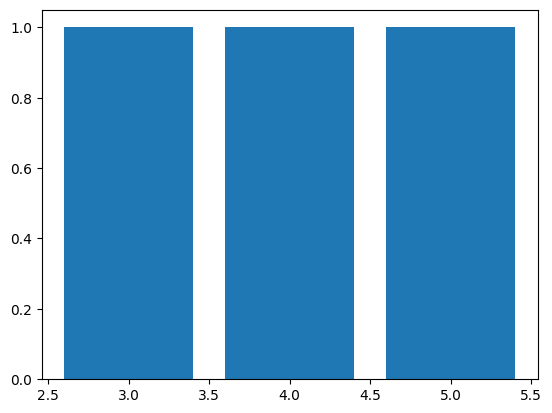

No of dimensions used for 10 classes -  10


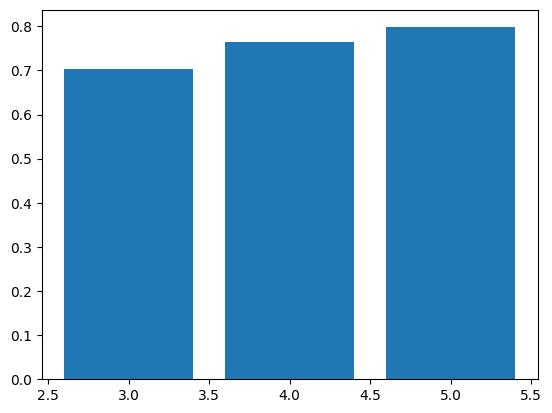

In [59]:
for i in results['quantum'].keys():
        print ('No of dimensions used for 10 classes - ', i)
        qubits, accuracies = list(zip(*results['quantum'][i]))

        plt.bar(qubits, accuracies)
        plt.show()

for i in results['classical'].keys():
        print ('No of dimensions used for 10 classes - ', i)
        qubits, accuracies = list(zip(*results['quantum'][i]))

        plt.bar(qubits, accuracies)
        plt.show()
